In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
from annoy import AnnoyIndex
from sklearn.model_selection import train_test_split

import config
from doppler.image_utils import read_img, display_n_images

In [3]:
annoy_idx_file = os.path.join(config.working_dir, 'annoy_index.ann')
annoy_idx2dhash =  os.path.join(config.working_dir, 'annoy_idx2dhash.json')

In [4]:
df_conv = pd.read_csv(config.logits_file, index_col=0)

In [5]:
df_conv.head(2)

,conv_0,conv_1,conv_2,conv_3,conv_4,conv_5,conv_6,conv_7,conv_8,conv_9,...,conv_2039,conv_2040,conv_2041,conv_2042,conv_2043,conv_2044,conv_2045,conv_2046,conv_2047,f_img
de199bce51eca611,0.171140,0.821729,1.545403,0.484026,0.493857,0.201970,0.532051,0.243506,0.137374,1.018628,...,0.549163,0.045832,1.109954,0.698326,0.147469,0.475100,0.073677,0.026989,0.039199,/mnt/n1p1/data/platforms/reddit/media/dd/bs/Dd...
9a0f8793135093b3,0.062129,1.315232,0.039969,0.081984,1.519520,0.488671,0.596972,0.106461,0.368639,0.229714,...,0.045548,0.383502,0.050320,0.006937,0.141298,0.595841,0.080084,0.178390,0.113449,/mnt/n1p1/data/platforms/reddit/media/kb/6a/kb...


In [6]:
feats = df_conv[config.cols_conv_feats]
f_name = df_conv['f_img']

In [7]:
n_trees = 100
n_dims = config.n_dimensions
metric = 'euclidean'

In [8]:
ann = AnnoyIndex(n_dims, metric=metric)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(feats, f_name, 
                                                    test_size=.1, 
                                                    random_state=303)

In [10]:
len(X_train), len(X_test)

(56724, 6303)

In [71]:
class AnnoyIndexPlus(AnnoyIndex):
    def __init__(self, *args, **kwargs):
        AnnoyIndex.__init__(self, *args, **kwargs)
        self.idx2dhash = {}
    
    def build_ann_idx(self, df : pd.DataFrame):
        '''
        Given a dataframe, iterates through each row to build the annoy index.
        Also creates a dict, that mads the annoy index to the dhash fo the image
        '''
        start_idx = self.get_n_items()
        for i, (dhash, vector) in tqdm(enumerate(df.iterrows()), 
                                  disable = not self.verbose):
            j = start_idx + i
            self.add_item(j, vector.values)
            self.idx2dhash[j] = dhash

    def update_ann_index(self, df):
        '''
        Updates the annoy index.
        '''
        self.build_ann_idx(df)
        
    def load_idx2dhash(fn):
        '''
        Loads the lookup
        '''
        with open(fn, 'r') as f:
            self.idx2dhash = json.loads(f.read())
    
    def save_idx2dhash(fn):
        '''
        Saves the lookup
        '''
        with open(fn, 'w') as f:
            f.write(json.dumps(self.idx2dhash))

In [72]:
ann2 = AnnoyIndexPlus(n_dims, metric=metric)

In [73]:
ann2.verbose = 1

In [74]:
ann2.build_ann_idx(X_train)

56724it [00:18, 3140.71it/s]


In [75]:
ann2.get_n_items()

56724

In [76]:
# make the file search-able
ann2.build(n_trees=n_trees)

True

In [77]:
ann2.get_nns_by_item(56722, n=4)

[56722, 1351, 53516, 40875]

In [78]:
ann2.update_ann_index(X_test)

6303it [00:02, 3079.92it/s]


In [79]:
ann2.build(n_trees=n_trees)

True

In [80]:
ann2.get_n_items()

63027

In [81]:
ann2.get_nns_by_item(6051|0, n=4)

[6051, 51484, 30083, 39718]

In [82]:
def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

def display_n_images(imgs, per_row=4):
    '''
    Plots a row of images
    '''
    for i in range(len(imgs)):
        if i % 4 == 0:
            _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(24, 6))
        j = i % 4
        image =  imgs[i]
        image = resize_img_to_array(image)
        ax[j].imshow(image)
        ax[j].axis('off')    
#         ax[j].annotate(distance[i],
#                       (0,0), (0, -32), xycoords='axes fraction', 
#                        textcoords='offset points', va='top')

In [84]:
i = 11
input_vector = X_test.iloc[i]
input_file = y_test.iloc[i]

In [86]:
ann2.get_n_items()

63027

In [87]:
idx_nearest_neighbors, distances = ann2.get_nns_by_vector(input_vector, 
                                                         n=12, include_distances=True)

In [88]:
idx_nearest_neighbors

[8055,
 51409,
 39887,
 5199,
 28935,
 49878,
 1452,
 31467,
 40946,
 18353,
 6809,
 15531]

In [93]:
[ann2.idx2dhash.get(idx) for idx in idx_nearest_neighbors]

['7667b3cc30cbdb35',
 '7393f9f835705d4f',
 'a5a361e9e3e3c9c9',
 'adaa69e9e3e3c9c9',
 '307476372d2d394a',
 'ddd539ff73ba9b9b',
 'a52b73e1e3e3c9c9',
 'f9581baf2535aeaa',
 'e5c999e9e3e3c3c9',
 'deb6949ba58cd919',
 '49c9c98d9c8d8fe0',
 '2333352166e6a626']

In [89]:
files_nearest_neighbors = y_train.iloc[idx_nearest_neighbors]

In [90]:
imgs = [Image.open(f) for f in files_nearest_neighbors]

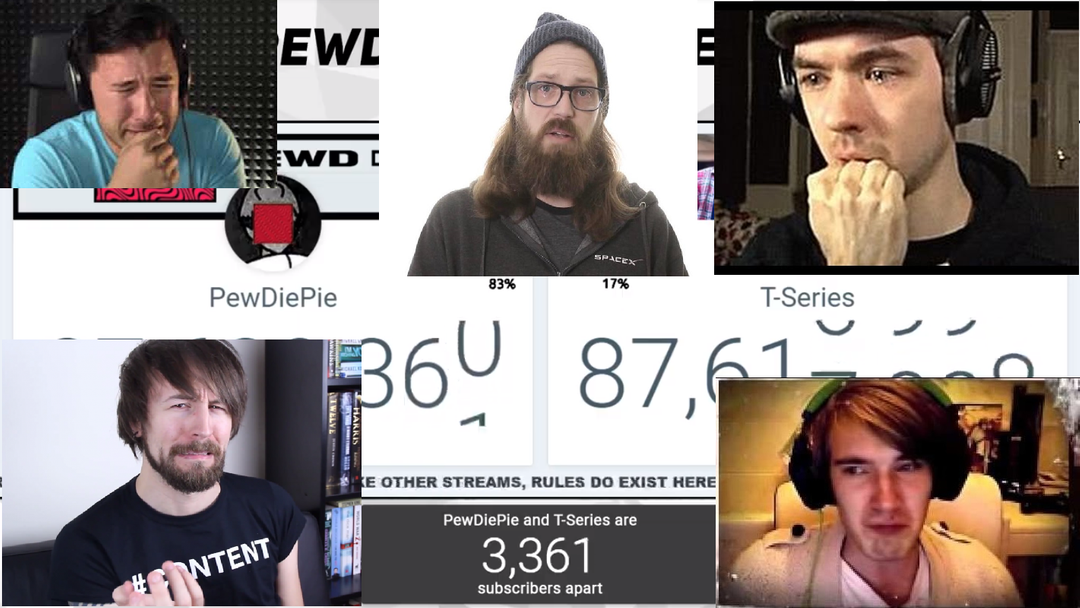

In [91]:
read_img(input_file)

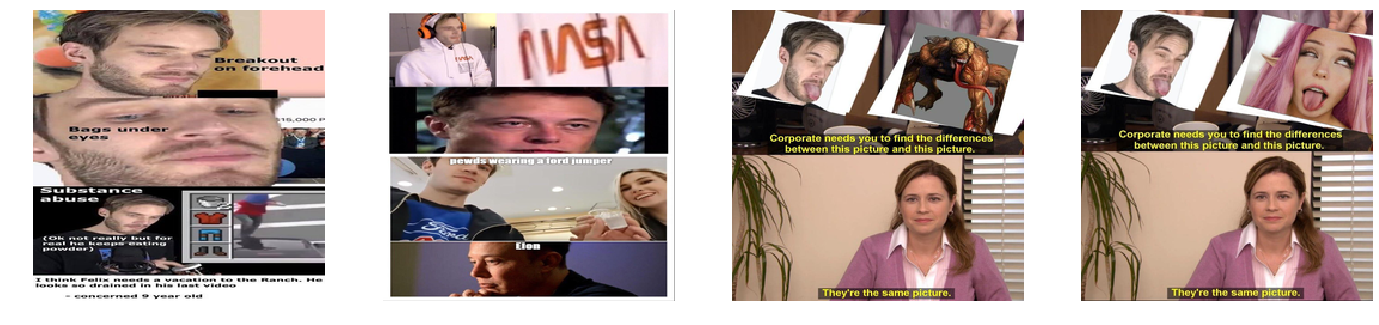

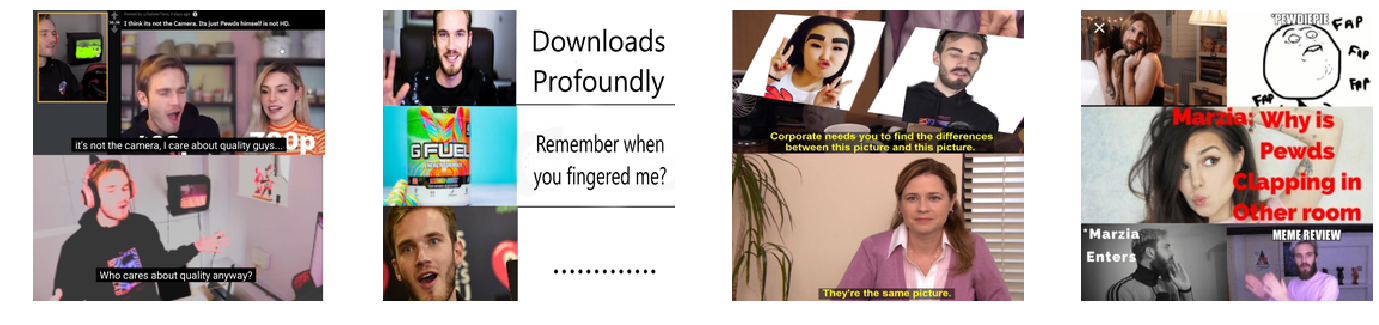

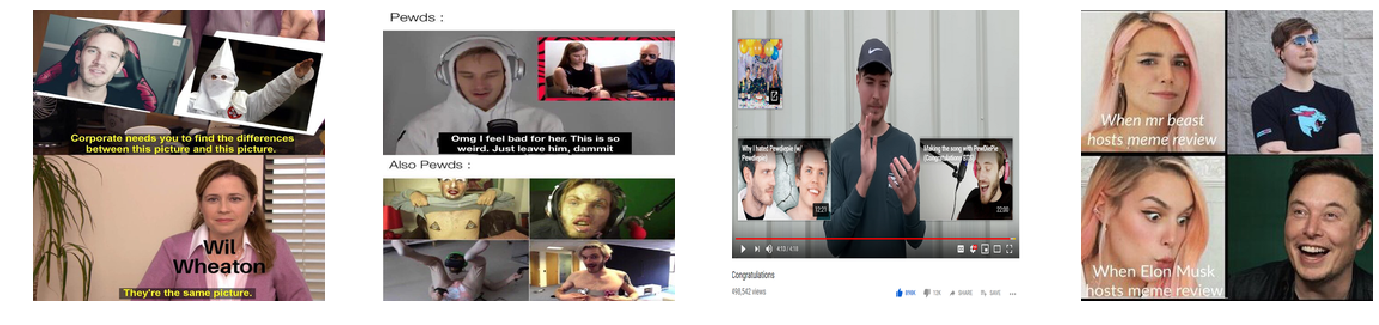

In [92]:
display_n_images(imgs, per_row=4)